### Exercise 3: Clustering Using PCA and Vectorization Techniques

##### Import the libraries necessary for this project.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import FastText
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import HDBSCAN
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#### 1. Transform the Data

##### Load BBC News and 20 Newsgroups datasets and print the first 5 rows to get the overview of these dataframes.

In [2]:
bbc_df = pd.read_csv("datasets/bbc_news_test.csv")
bbc_df.head(5)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


##### The following code snippet is taken from the file load_20newsgroups.py (provided in the course materials).

In [3]:
data_20newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents_20newsgroups = data_20newsgroups.data
labels_20newsgroups = data_20newsgroups.target
labels_names_20newsgroups = data_20newsgroups.target_names
news_dict = {
    'label': labels_20newsgroups,
    'comment': documents_20newsgroups,
}
news_df = pd.DataFrame(news_dict)
news_df['label_name'] = news_df['label'].apply(lambda x: labels_names_20newsgroups[x])

_, x_test_news, _, y_test_news = train_test_split(
    news_df,
    news_df['label'],
    test_size=0.1,
    random_state=42,
    stratify=news_df['label']
)

x_test_news.head(5)

,label,comment,label_name
16313,8,If anyone has the current Moto Guzzi National ...,rec.motorcycles
12,19,930418\n\nDo what thou wilt shall be the whole...,talk.religion.misc
5705,6,,misc.forsale
17808,1,\n Yes. There are many methods of renderin...,comp.graphics
9913,10,\n\n\n\n\n\n\n\n\nAs if an aluminum stick bein...,rec.sport.hockey


##### Convert each line in our text corpus into a list of phrases by applying the split() function.

In [4]:
bbc_sentences = [line.split() for line in bbc_df['Text']]
news_sentences = [line.split() for line in x_test_news['comment']]

##### Create the word_embeddings function to initialize each word embedding method in order to experiment and see the evaluation results.

In [5]:
def word_embeddings(ds, init):
    if init == 'TFIDF':
        vectorizer = TfidfVectorizer()
        output = vectorizer.fit_transform(ds)
    elif init == 'FastText':
        model = FastText(ds, vector_size=100, window=5, min_count=1, sg=0, epochs=10)
        output = model.wv.vectors
    elif init == 'Word2Vec':
        model = Word2Vec(ds, vector_size=100, window=5, sg=0)
        output = model.wv.vectors
    else:
        raise Exception('Invalid Method')
    return output

##### Apply word_embeddings function to both the BBC News and 20 Newsgroups datasets.

In [6]:
method = 'TFIDF' #TFIDF,FastText,Word2Vec
bbc_matrix = word_embeddings(bbc_df['Text'] if method == 'TFIDF' else bbc_sentences, method)
news_matrix = word_embeddings(x_test_news['comment'] if method == 'TFIDF' else news_sentences, method)

#### 2. Apply Clustering Algorithms

##### Apply K-Means, Agglomerative Clustering and HDBSCAN clustering algorithms using word embedding to both the BBC News and 20 Newsgroups datasets. Change method parameter in order to compare the results with evaluation metrics.

In [7]:
def apply_clustering(embedding_matrix, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(embedding_matrix)

    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agglomerative.fit_predict(embedding_matrix.toarray() if method == 'TFIDF' else embedding_matrix)
    
    hdbscan_clustering = HDBSCAN(min_cluster_size=n_clusters)
    hdbscan_clustering.fit(embedding_matrix)
    return kmeans_labels,agg_labels,hdbscan_clustering.labels_

kmeans_bbc_labels,agg_bbc_labels,hdbscan_bbc_labels = apply_clustering(bbc_matrix,5)
kmeans_news_labels,agg_news_labels,hdbscan_news_labels = apply_clustering(news_matrix,20)

#### 3. Evaluate and Interpret Results

##### Create evaluate clustering function to assess the performance of clustering using metrics such as NMI, ARI, and AMI.

In [8]:
def evaluate_clustering(true_labels, predicted_labels):
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    return nmi, ari, ami

##### Word2Vec and FastText captures captures word semantics, but TF-IDF is fast to compute. Selected TF-IDF method because the number of labels in the clustering results are same from the number of real labels.

In [9]:
bbc_true_labels = bbc_df['Category']
news_true_labels = x_test_news['label_name']

nmi_bbc_kmeans, ari_bbc_kmeans, ami_bbc_kmeans = evaluate_clustering(bbc_true_labels, kmeans_bbc_labels)
nmi_bbc_agg, ari_bbc_agg, ami_bbc_agg = evaluate_clustering(bbc_true_labels, agg_bbc_labels)
nmi_bbc_hdbscan, ari_bbc_hdbscan, ami_bbc_hdbscan = evaluate_clustering(bbc_true_labels, hdbscan_bbc_labels)

nmi_news_kmeans, ari_news_kmeans, ami_news_kmeans = evaluate_clustering(news_true_labels, kmeans_news_labels)
nmi_news_agg, ari_news_agg, ami_news_agg = evaluate_clustering(news_true_labels, agg_news_labels)
nmi_news_hdbscan, ari_news_hdbscan, ami_news_hdbscan = evaluate_clustering(news_true_labels, hdbscan_news_labels)

results = {
    'K-Means BBC News': [nmi_bbc_kmeans, ari_bbc_kmeans, ami_bbc_kmeans],
    'Agglomerative BBC News': [nmi_bbc_agg, ari_bbc_agg, ami_bbc_agg],
    'HDBSCAN BBC News': [nmi_bbc_hdbscan, ari_bbc_hdbscan, ami_bbc_hdbscan],
    'K-Means 20Newsgroups': [nmi_news_kmeans, ari_news_kmeans, ami_news_kmeans],
    'Agglomerative 20Newsgroups': [nmi_news_agg, ari_news_agg, ami_news_agg],
    'HDBSCAN 20Newsgroups': [nmi_news_hdbscan, ari_news_hdbscan, ami_news_hdbscan]
}
results_df = pd.DataFrame(results, index=['NMI', 'ARI', 'AMI'])
print(results_df)

     K-Means BBC News  Agglomerative BBC News  HDBSCAN BBC News  \
NMI          0.639166                0.552475          0.250289   
ARI          0.530289                0.490140          0.013362   
AMI          0.637872                0.550898          0.223640   

     K-Means 20Newsgroups  Agglomerative 20Newsgroups  HDBSCAN 20Newsgroups  
NMI              0.120320                    0.226717              0.031266  
ARI              0.015135                    0.034244              0.001444  
AMI              0.081138                    0.195346              0.001627  


##### Evaluating the clustering results using Silhouette Score.

In [10]:
score_df = pd.DataFrame({
    'K-Means': [silhouette_score(bbc_matrix, kmeans_bbc_labels), silhouette_score(news_matrix, kmeans_news_labels)],
    'Agglomerative': [silhouette_score(bbc_matrix, agg_bbc_labels), silhouette_score(news_matrix, agg_news_labels)],
}, index=['Silhouette Score BBC News(n=5)', 'Silhouette Score 20Newsgroups(n=20)'])
print(score_df)

                                      K-Means  Agglomerative
Silhouette Score BBC News(n=5)      -0.004575       0.004121
Silhouette Score 20Newsgroups(n=20)  0.001716      -0.019632


#### 4. Fine-Tune with PCA

##### In order to improve clustering performance reduce dimensionality using PCA. Create plot to identify the optimal number of principal components.

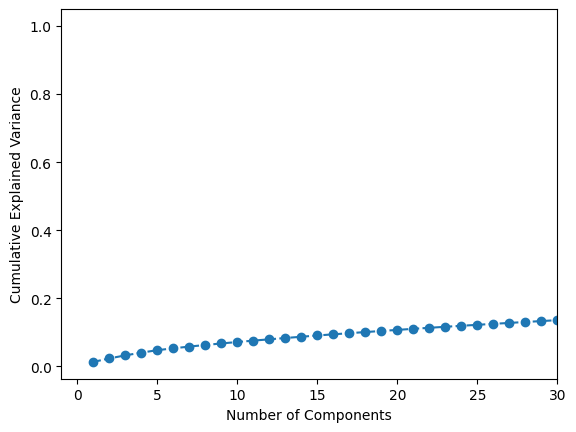

In [11]:
pca = PCA()
pca.fit(bbc_matrix.toarray())

plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o',linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim(-1,30)
plt.show()

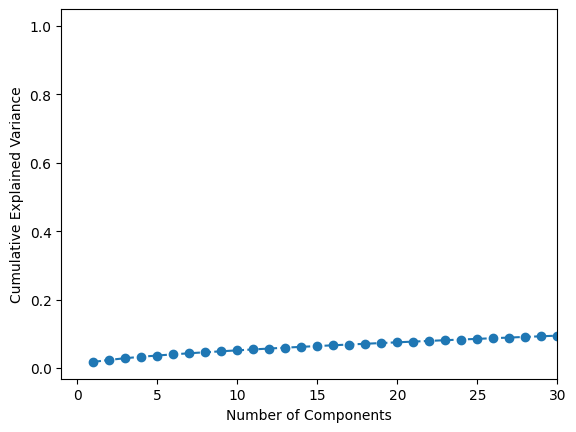

In [12]:
pca = PCA()
pca.fit(news_matrix.toarray())

plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o',linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim(-1,30)
plt.show()

##### Perform PCA with the chosen numbers of components.

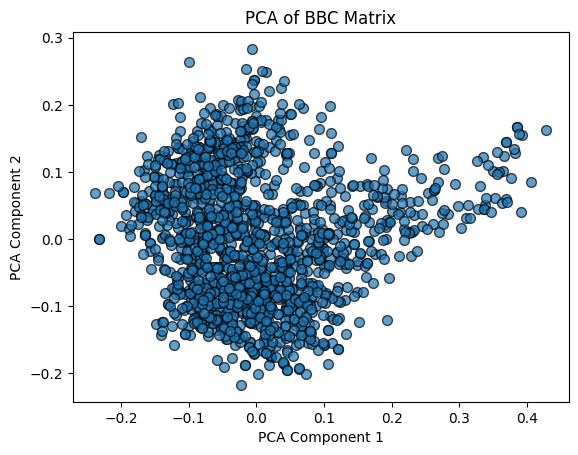

In [13]:
pca = PCA(n_components=2)
bbc_pca = pca.fit_transform(bbc_matrix.toarray())

plt.scatter(bbc_pca[:, 0], bbc_pca[:, 1], edgecolors='k', alpha=0.7, s=50)
plt.title('PCA of BBC Matrix')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

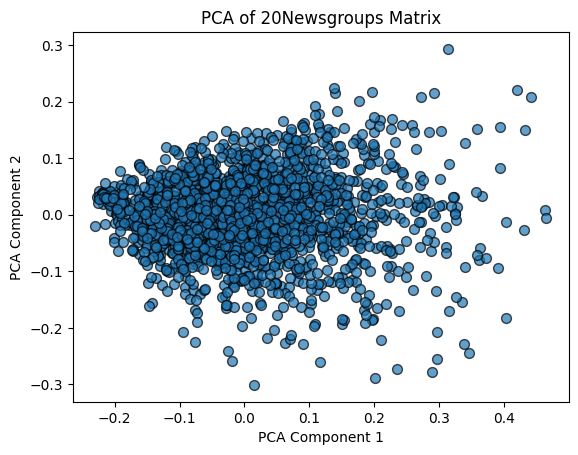

In [14]:
pca = PCA(n_components=2)
news_pca = pca.fit_transform(news_matrix.toarray())

plt.scatter(news_pca[:, 0], news_pca[:, 1], edgecolors='k', alpha=0.7, s=50)
plt.title('PCA of 20Newsgroups Matrix')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

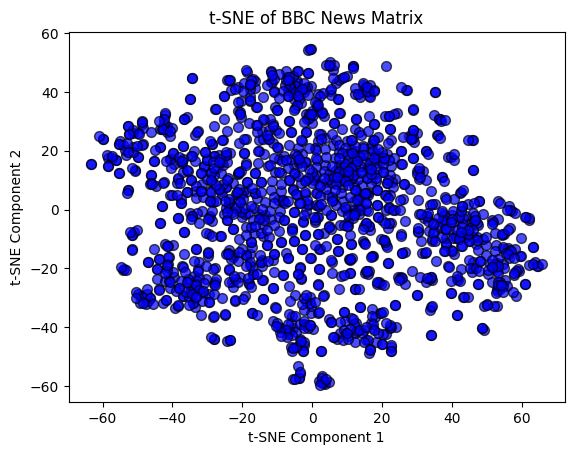

In [15]:
tsne = TSNE(n_components=2, random_state=42)
bbc_tsne = tsne.fit_transform(bbc_matrix.toarray())

plt.scatter(bbc_tsne[:, 0], bbc_tsne[:, 1], c='blue', edgecolors='k', alpha=0.7, s=50)
plt.title('t-SNE of BBC News Matrix')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

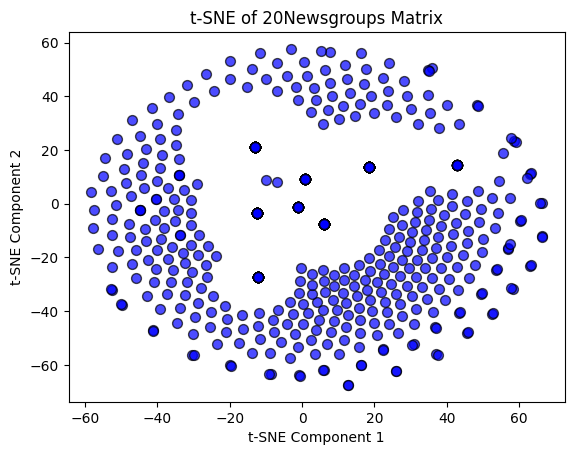

In [16]:
tsne = TSNE(n_components=2, random_state=42)
news_tsne = tsne.fit_transform(news_matrix.toarray())

plt.scatter(news_tsne[:, 0], news_tsne[:, 1], c='blue', edgecolors='k', alpha=0.7, s=50)
plt.title('t-SNE of 20Newsgroups Matrix')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

#### 5. Visualization

##### Create bar plot to compare the performance metrics of clustering results.

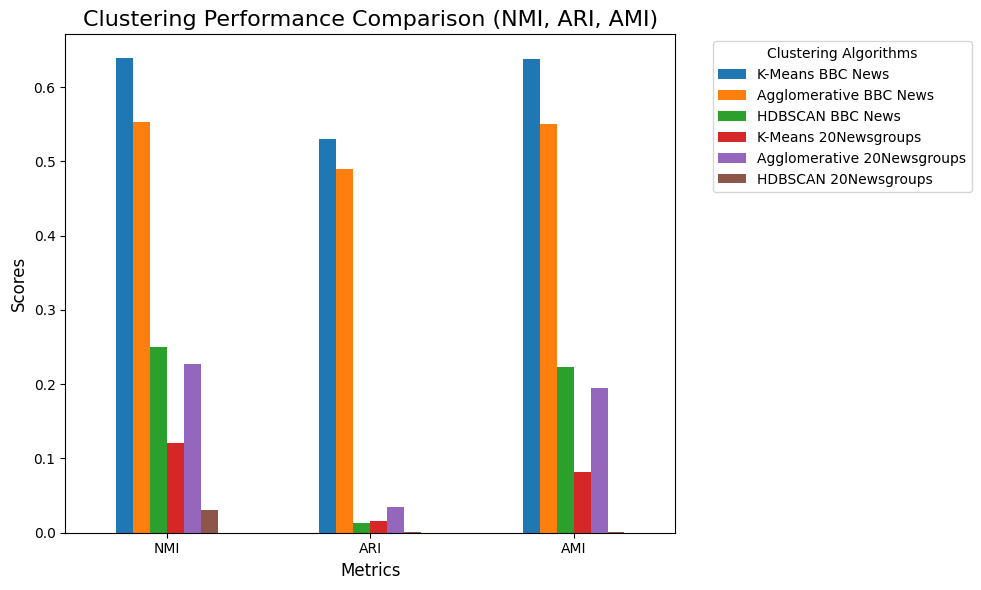

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
results_df.plot(kind='bar', ax=ax)
plt.title('Clustering Performance Comparison (NMI, ARI, AMI)', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Clustering Algorithms', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()